#Paquetes necesarios

In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Carga imagen y convierte a RGB

(938, 473, 3)


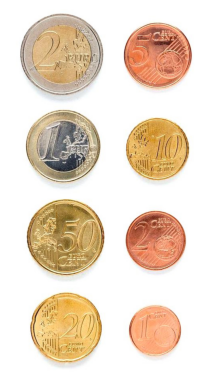

In [49]:
# Cargar las imágenes
image_fra = cv2.imread('FRA.png')
image_pel = cv2.imread('PEL.png')
image_tar = cv2.imread('TAR.png')

# Cargar las imágenes
image_fra_plus = cv2.imread('fragment-03-olympus-10-01-2020.JPG')
image_pel_plus = cv2.imread('pellet-03-olympus-10-01-2020.JPG')
image_tar_plus = cv2.imread('tar-03-olympus-10-01-2020.JPG')

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

In [196]:
cuenta_acumulada = 0
pixel_A_MM = 0

def Hough(imagen):
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    imagen_suavizada = cv2.medianBlur(imagen_gris, 5)

    circulos = cv2.HoughCircles(
        imagen_suavizada,
        cv2.HOUGH_GRADIENT,
        1,
        100,
        param1=100,
        param2=50,
        minRadius=50,
        maxRadius=150
    )

    mascara = np.zeros_like(imagen)
    if circulos is not None:
        circulos = np.uint16(np.around(circulos))
        for i in circulos[0, :]:
            cv2.circle(mascara, (i[0], i[1]), i[2], (255, 255, 255), -1)

    return cv2.bitwise_and(imagen, mascara)

def sacar_monedas(radius):
    global pixel_A_MM

    radius_in_pixels = int(radius)

    if pixel_A_MM == 0:
        radio_mm = radius_in_pixels / monedas[moneda_actual]
        pixel_A_MM = radio_mm
    else:
        radio_mm = radius_in_pixels / pixel_A_MM

    valor_verdadero = radius_in_pixels / pixel_A_MM
    tolerancia = 1.5

    moneda_detectada = None
    menor_diferencia = float('inf')
    
    for NombreMonedas in monedas.items():
        diferencia = abs(valor_verdadero - NombreMonedas[1])
        
        if diferencia < tolerancia and diferencia < menor_diferencia:
            menor_diferencia = diferencia
            moneda_detectada = NombreMonedas[0]

    return moneda_detectada

def procesar_imagen(imagen, monedas, valores_monedas, umbral=150, area_minima=2000):
    global moneda_actual

    NuevaImagen = Hough(imagen)
    imagen_gris = cv2.cvtColor(NuevaImagen, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(imagen_gris, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    hitboxes = []
    for contour in contours:
        area = cv2.contourArea(contour)

        if area > area_minima:

            (x, y), radius_in_pixels = cv2.minEnclosingCircle(contour)

            center = (int(x), int(y))

            hitboxes.append((center, radius_in_pixels))

    cv2.imshow('Moneda detectada', imagen)
    mostrar_ventana_info('Sin Valor', valores_monedas)
    cv2.setMouseCallback('Moneda detectada', lambda event, x, y, flags, param: click_event(event, x, y, hitboxes, valores_monedas))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def click_event(event, x, y, hitboxes, valores_monedas):
    if event == cv2.EVENT_LBUTTONDOWN:
        for (center, radius) in hitboxes:
            distancia = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
            if distancia <= radius:
                nombre = sacar_monedas(radius)

                print(f'Has hecho clic en: {nombre}')

                generar_nueva_moneda()
                mostrar_ventana_info(nombre, valores_monedas)
                break

def mostrar_ventana_info(nombre_moneda, valores_monedas):
    global cuenta_acumulada

    ventana_info = np.zeros((300, 700, 3), dtype=np.uint8)

    ventana_info[0:100, :] = [0, 0, 255]
    ventana_info[100:200, :] = [255, 0, 0]
    ventana_info[200:300, :] = [0, 255, 0]

    moneda_text = f"Moneda aleatoria: {moneda_actual}"
    (text_w, text_h), _ = cv2.getTextSize(moneda_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.putText(ventana_info, moneda_text, ((700 - text_w) // 2, (100 + text_h) // 2),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    (text_w, text_h), _ = cv2.getTextSize(nombre_moneda, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.putText(ventana_info, nombre_moneda, ((700 - text_w) // 2, 100 + (100 + text_h) // 2),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cuenta_acumulada += valores_monedas[nombre_moneda]
    texto_inferior = f"Cuenta acumulada = {cuenta_acumulada:.2f} euros"
    (text_w, text_h), _ = cv2.getTextSize(texto_inferior, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.putText(ventana_info, texto_inferior, ((700 - text_w) // 2, 200 + (100 + text_h) // 2),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Info de la Moneda', ventana_info)

monedas = {
    '1 centimo': 8.13,
    '2 centimos': 9.38,
    '5 centimos': 10.63,
    '10 centimos': 9.88,
    '20 centimos': 11.13,
    '50 centimos': 12.13,
    '1 euro': 11.63,
    '2 euros': 12.88
}

valores_monedas = {
    'Sin Valor': 0.00,
    '1 centimo': 0.01,
    '2 centimos': 0.02,
    '5 centimos': 0.05,
    '10 centimos': 0.10,
    '20 centimos': 0.20,
    '50 centimos': 0.50,
    '1 euro': 1.00,
    '2 euros': 2.00
}

def moneda_aleatoria():
    monedas_posibles = ['1 centimo', '2 centimos', '5 centimos', '10 centimos', '20 centimos', '50 centimos', '1 euro', '2 euros']
    return random.choice(monedas_posibles)

def generar_nueva_moneda():
    global moneda_actual
    moneda_actual = moneda_aleatoria()

moneda_actual = '10 centimos'
imagen_original = cv2.imread('Monedas/Monedas2.jpeg')

procesar_imagen(imagen_original, monedas, valores_monedas)
cv2.waitKey(0)
cv2.destroyAllWindows()

El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas desde características geométricas y/o de apariencia, para distinguir en las imágenes completas, las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

El siguiente ejemplo, muestra el modo de obtener la matriz de confusión para un hipotético problema con cuatro clases, y valores de anotación (variable y) y predicción (variable y_pred) obtenidos de forma aleatoria.

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

In [192]:
# Apartado del Fragmento
def obtener_valores_geometricos_fragmentos(contorno):
    valores = {}

    # 1. Angularidad (número de vértices)
    epsilon = 0.01 * cv2.arcLength(contorno, True)
    aproximacion = cv2.approxPolyDP(contorno, epsilon, True)
    valores['angularidad'] = len(aproximacion)

    # 2. Relación ancho-alto (rectangularidad)
    x, y, w, h = cv2.boundingRect(contorno)
    valores['rectangularidad'] = w / h if h != 0 else 0

    # 3. Compacidad (área / perímetro^2)
    area = cv2.contourArea(contorno)
    perimetro = cv2.arcLength(contorno, True)
    valores['compacidad'] = area / (perimetro ** 2) if perimetro != 0 else 0

    # 4. Variabilidad de distancias desde el centroide hasta el contorno
    M = cv2.moments(contorno)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        distancias = [np.linalg.norm(np.array([cx, cy]) - punto[0]) for punto in contorno]
        valores['variabilidad_distancias'] = np.std(distancias)
    else:
        valores['variabilidad_distancias'] = 0

    return valores

def es_fragmento(valores):

    # Condición 1: Angularidad debe tener más de 2 vértices
    if valores['angularidad'] <= 2:
        return False
    
    # Condición 2: La relación ancho-alto acepta cualquier valor amplio
    if not (valores['rectangularidad'] < 0.8 or valores['rectangularidad'] > 1.2):
        return False

    # Condición 3: La compacidad se permite prácticamente cualquier valor no excesivo
    if valores['compacidad'] >= 0.1:
        return False

    # Condición 4: La variabilidad de distancias es permisiva
    if valores['variabilidad_distancias'] <= 0.1:
        return False

    # Si pasa todas las condiciones, es un fragmento
    return True

def calcular_probabilidad_fragmentos(contornos):
    total_contornos = len(contornos)
    fragmentos_detectados = 0

    if total_contornos == 0:
        return 0.0  # Si no hay contornos, no se puede decir que es un fragmento

    for contorno in contornos:
        # Calcular los valores geométricos del contorno
        valores = obtener_valores_geometricos_fragmentos(contorno)

        # Contar si el contorno es clasificado como fragmento
        if es_fragmento(valores):
            fragmentos_detectados += 1

    # Calcular el porcentaje de contornos que son fragmentos
    porcentaje_fragmentos = (fragmentos_detectados / total_contornos) * 100

    return porcentaje_fragmentos

# Apartado del pellet

def verificar_geometria(valores):
    resultado = []
    
    value = 0

    if valores.get('circularidad', 0) > 0.75:
        resultado.append("Es circulo o elíptico - check pasado por test de circularidad")
        value += 1
    
    if valores.get('relacion_ejes') and 0.8 <= valores['relacion_ejes'] <= 1.2:
        resultado.append("Es circulo o elíptico - check pasado por test de relación de ejes")
        value += 1
    
    return resultado, value

def obtener_valores_geometricos_pellet(contornos):
    Valor = 0

    for contorno in contornos:

        if cv2.contourArea(contorno) < 10:  # Ajusta el umbral según sea necesario
            continue

        valores = {}
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)

        if perimetro == 0 or area == 0:
            valores['error'] = "Perímetro o área cero - contorno inválido"
            continue  # Saltar este contorno

        circularidad = (4 * 3.1416 * area) / (perimetro ** 2)
        valores['circularidad'] = circularidad

        #print(circularidad)  # Para depuración

        if len(contorno) >= 5:
            elipse = cv2.fitEllipse(contorno)
            _, (eje_mayor, eje_menor), _ = elipse
            relacion_ejes = eje_mayor / eje_menor if eje_menor > 0 else 0
            valores['relacion_ejes'] = relacion_ejes

        Numero = verificar_geometria(valores)
        Valor += Numero[1]

    return Valor

# Apartado del alquitrán
def determinar_color_dominante(colores_promedios):
    umbral_negro = 30
    cont_negro = 0
    cont_otros = 0
    color_otros = []

    for color in colores_promedios:
        b, g, r = color  # Los colores promedio están en formato BGR

        if b < umbral_negro and g < umbral_negro and r < umbral_negro:
            cont_negro += 1
        else:
            cont_otros += 1
            color_otros.append(color)

    if cont_negro > cont_otros:
        promedio_negro = np.mean([b, g, r])
        color_promedio = np.array([promedio_negro, promedio_negro, promedio_negro])
        distancia_negro = np.linalg.norm(np.array([0, 0, 0]) - color_promedio)
        distancia_blanco = np.linalg.norm(np.array([255, 255, 255]) - color_promedio)
        porcentaje_alquitran = max(0, 100 - (distancia_negro / distancia_blanco) * 100)
        return "Alquitrán", porcentaje_alquitran
    else:
        promedio_otros = np.mean(color_otros, axis=0) if color_otros else (0, 0, 0)
        color_promedio = np.mean(promedio_otros)
        distancia_negro = np.linalg.norm(np.array([0, 0, 0]) - promedio_otros)
        distancia_blanco = np.linalg.norm(np.array([255, 255, 255]) - promedio_otros)
        porcentaje_alquitran = max(0, 100 - (distancia_negro / distancia_blanco) * 100)
        return f"El color predominante es otro (RGB): {promedio_otros[::-1]}", porcentaje_alquitran

def color_promedio_en_contorno(imagen, contorno):
    mascara = np.zeros(imagen.shape[:2], dtype="uint8")
    cv2.drawContours(mascara, [contorno], -1, 255, thickness=cv2.FILLED)
    promedio_color = cv2.mean(imagen, mask=mascara)[:3]
    return promedio_color


# Calculo de la imagen
def eliminar_contornos_pequenos(contornos, area_minima=100):
    return [c for c in contornos if cv2.contourArea(c) > area_minima]

def normalizar_porcentajes(porcentaje_pellet, porcentaje_alquitran, porcentaje_fragmento):
    total = porcentaje_pellet + porcentaje_alquitran + porcentaje_fragmento

    if total == 0:
        return 0, 0, 0

    # Ajustar los porcentajes para que sumen exactamente 100
    porcentaje_pellet = (porcentaje_pellet / total) * 100
    porcentaje_alquitran = (porcentaje_alquitran / total) * 100
    porcentaje_fragmento = (porcentaje_fragmento / total) * 100

    return porcentaje_pellet, porcentaje_alquitran, porcentaje_fragmento

# Función para calcular los porcentajes
def determinar_clasificacion(imagen, titulo):
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    _, umbralizada = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contornos, _ = cv2.findContours(umbralizada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Paso 1: Determinar si el color predominante es alquitrán
    colores_promedios = [color_promedio_en_contorno(imagen, c) for c in contornos]
    _, porcentaje_alquitran = determinar_color_dominante(colores_promedios)

    # Paso 2: Evaluar la geometría para determinar si es un pellet
    Total_Checks_Pellets = obtener_valores_geometricos_pellet(contornos)
    porcentaje_pellet = (Total_Checks_Pellets / (2 * len(contornos))) * 100 if (2 * len(contornos)) > 0 else 0


    # Paso 3: Calcular el porcentaje de fragmento
    porcentaje_fragmento = calcular_probabilidad_fragmentos(contornos)

    nuevo_porcentaje_pellet, nuevo_porcentaje_alquitran, nuevo_porcentaje_fragmento = normalizar_porcentajes(
        porcentaje_pellet, porcentaje_alquitran, porcentaje_fragmento)

    if nuevo_porcentaje_alquitran >= max(nuevo_porcentaje_pellet, nuevo_porcentaje_fragmento):
        return f"Alquitrán ({nuevo_porcentaje_alquitran:.2f}% certeza)", nuevo_porcentaje_pellet, nuevo_porcentaje_alquitran, nuevo_porcentaje_fragmento
    elif nuevo_porcentaje_pellet >= max(nuevo_porcentaje_alquitran, nuevo_porcentaje_fragmento):
        return f"Pellet ({nuevo_porcentaje_pellet:.2f}% certeza)" , nuevo_porcentaje_pellet, nuevo_porcentaje_alquitran, nuevo_porcentaje_fragmento
    else:
        return f"Fragmento ({nuevo_porcentaje_fragmento:.2f}% certeza)" , nuevo_porcentaje_pellet, nuevo_porcentaje_alquitran, nuevo_porcentaje_fragmento

# Ejemplo de uso:
clasificacion = determinar_clasificacion(image_tar, 'Clasificación')
print(clasificacion[0])

Alquitrán (57.35% certeza)


In [193]:
def aplicar_rotacion(imagen, angulo):
    (h, w) = imagen.shape[:2]
    centro = (w // 2, h // 2)
    matriz_rotacion = cv2.getRotationMatrix2D(centro, angulo, 1.0)
    imagen_rotada = cv2.warpAffine(imagen, matriz_rotacion, (w, h))
    return imagen_rotada

def aplicar_traslacion(imagen, tx, ty):
    matriz_traslacion = np.float32([[1, 0, tx], [0, 1, ty]])
    imagen_trasladada = cv2.warpAffine(imagen, matriz_traslacion, (imagen.shape[1], imagen.shape[0]))
    return imagen_trasladada

def aplicar_ruido(imagen):
    ruido = np.random.normal(0, 25, imagen.shape).astype(np.uint8)
    imagen_con_ruido = cv2.add(imagen, ruido)
    return imagen_con_ruido

def ajustar_brillo(imagen, valor_brillo):
    imagen_ajustada = cv2.convertScaleAbs(imagen, alpha=1, beta=valor_brillo)
    return imagen_ajustada

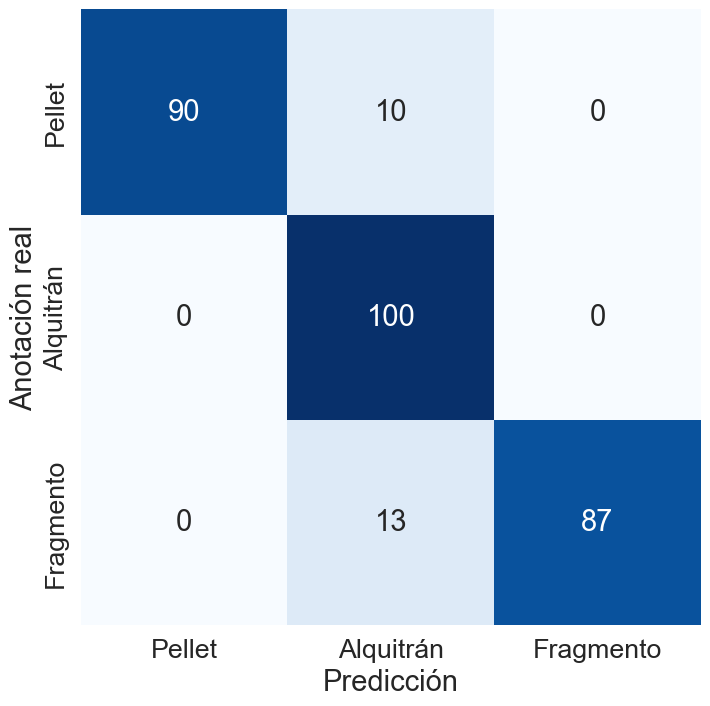

Accuracy: 0.9233333333333333
Precision: 0.9376693766937669
Recall: 0.9233333333333333
F1 Score: 0.924903563674059


In [195]:
# Función que simula las pruebas
def simular_pruebas(porcentaje_pellet, porcentaje_alquitran, porcentaje_fragmento, num_pruebas=100):
    resultados = {"Pellet": 0, "Alquitrán": 0, "Fragmento": 0}
    
    opciones = (
        ["Pellet"] * int(porcentaje_pellet) +
        ["Alquitrán"] * int(porcentaje_alquitran) +
        ["Fragmento"] * int(porcentaje_fragmento)
    )

    for _ in range(num_pruebas):
        resultado = random.choice(opciones)
        resultados[resultado] += 1
    
    return resultados

# Función para generar las imágenes con ruido
def generar_imagen_modificada(imagen, tipo_modificacion):
    if tipo_modificacion == "rotacion":
        return aplicar_rotacion(imagen, random.randint(-45, 45))
    elif tipo_modificacion == "traslacion":
        return aplicar_traslacion(imagen, random.randint(-30, 30), random.randint(-30, 30))
    elif tipo_modificacion == "ruido":
        return aplicar_ruido(imagen)
    elif tipo_modificacion == "brillo":
        return ajustar_brillo(imagen, random.randint(-50, 50))
    else:
        return imagen  # Devuelve la imagen original sin cambios

# Crear anotaciones y predicciones basadas en las pruebas
def generar_matriz_confusion(imagen, tipo, num_repeticiones=20):
    y_real = []
    y_pred = []
    
    for _ in range(num_repeticiones):
        for modificacion in ["original", "rotacion", "traslacion", "ruido", "brillo"]:
            # Generar la imagen modificada
            
            # Clasificar la imagen modificada
            clasificacion = determinar_clasificacion(imagen, 'Clasificación')
            
            # Simular pruebas con los porcentajes de la clasificación
            resultados_simulacion = simular_pruebas(clasificacion[1], clasificacion[2], clasificacion[3], num_pruebas=100)
            
            # Añadir a la matriz de confusión
            y_real.append(tipo)  # Añadimos la clase real
            y_pred.append(max(resultados_simulacion, key=resultados_simulacion.get))  # Añadimos la clase predicha
    
    return y_real, y_pred

# Generar matriz de confusión para las tres imágenes
def procesar_imagenes_para_matriz_confusion(image_pel, image_fra, image_tar):
    y_real_total = []
    y_pred_total = []

    # Pellets
    y_real, y_pred = generar_matriz_confusion(image_pel, 'Pellet')
    y_real_total.extend(y_real)
    y_pred_total.extend(y_pred)

    # Fragmentos
    y_real, y_pred = generar_matriz_confusion(image_fra, 'Fragmento')
    y_real_total.extend(y_real)
    y_pred_total.extend(y_pred)

    # Alquitrán
    y_real, y_pred = generar_matriz_confusion(image_tar, 'Alquitrán')
    y_real_total.extend(y_real)
    y_pred_total.extend(y_pred)

    return y_real_total, y_pred_total

# Mostrar la matriz de confusión y las métricas
def mostrar_matriz_confusion(y_real, y_pred):
    conf_matrix = confusion_matrix(y_real, y_pred, labels=["Pellet", "Alquitrán", "Fragmento"])
    
    plt.figure(figsize=(8,8))
    sns.set(font_scale=1.75)
    ax = sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt='d', 
        cbar=False, 
        cmap='Blues',
        xticklabels=["Pellet", "Alquitrán", "Fragmento"],
        yticklabels=["Pellet", "Alquitrán", "Fragmento"]
    )
    
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Anotación real")
    plt.show()

    # Cálculo de métricas
    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred, average='weighted')
    recall = recall_score(y_real, y_pred, average='weighted')
    f1score = f1_score(y_real, y_pred, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1score}")

# Ejemplo de uso (asegúrate de tener las imágenes cargadas: image_pel, image_fra, image_tar)
y_real_total, y_pred_total = procesar_imagenes_para_matriz_confusion(image_pel, image_fra, image_tar)

# Mostrar la matriz de confusión y las métricas
mostrar_matriz_confusion(y_real_total, y_pred_total)